In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from treams.jcyl._tmatrixc import globalt
import treams
import cavity

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

import jax.numpy as np
import numpy as onp
from scipy.constants import e, h, c as c0
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from diffable_aaa import aaa
from baryrat import BarycentricRational

POLARIZATION = 0 # 0=>TE ; 1=>TM
RADIUS = 110/2
NUM_CYL = 50

materials = [treams.Material(4.213**2 + 0.07j), treams.Material(1.723**2 + 0.01j)]
kzs=[0]

E_max = 2.43
E_min = 2.4

In [3]:
def _tm_cavity(E_ph, mmax=1, radius=RADIUS, pitch=165, A=200, L=1820, sigma=1000, num_cyl=NUM_CYL):
    omega = 2*np.pi*E_ph*(e/h)
    k0 = omega/c0*1e-9
    kzs = [0]
    positions = cavity.scatterer_positions(A, sigma, pitch, num_cyl, L)
    radii = np.array([RADIUS]*NUM_CYL)
    finalt, modes, positions = globalt(mmax, kzs, k0, radii, positions, materials, pol_filter=POLARIZATION)

    return finalt, modes, positions

def tm_cavity(E_phs: np.ndarray, L:float=1820) -> tuple[tuple[treams.PhysicsArray], tuple[treams.PhysicsArray]]:
    """returns the incident and scattered fields at a given (complex) Energy"""
    _tm_cavity(E_phs[0], L=L)[0]

    res = [_tm_cavity(E_ph, L=L)[0] for E_ph in tqdm(E_phs)]
    return np.array(res)

In [4]:
finalt, modes, positions = _tm_cavity(1)

In [5]:
pidx = np.argmin(np.abs(positions[:, 1]))
t_idx = np.argmax(modes[0]==pidx)

In [30]:
N_sample = 30
z_k_r = np.linspace(E_min, E_max, N_sample)
z_k_i = onp.random.normal(size=N_sample)*0.003 - 0.001

z_k = z_k_r + 1j*z_k_i

In [31]:
f_k = tm_cavity(z_k)[:,t_idx,t_idx]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/jd/miniconda3/envs/jat/lib/python3.9/site-packages/jax/_src/array.py:390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


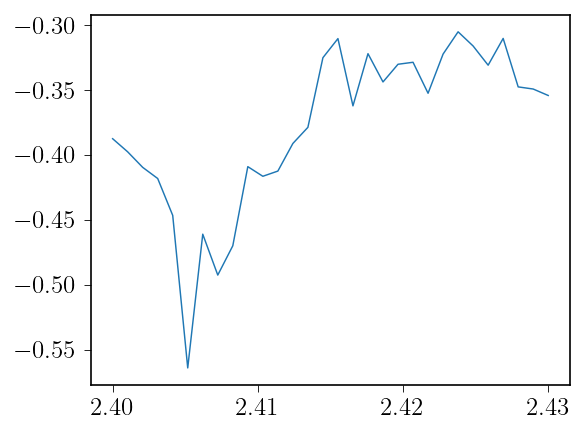

In [32]:
plt.plot(z_k_r, f_k)

In [33]:
def f(A):
    tm = _tm_cavity(2.4, A=A)[0]
    return np.real(tm[t_idx,t_idx])

In [34]:
import jax
g = jax.grad(f)
g(1820.0)

Array(0.00010561, dtype=float64, weak_type=True)

In [11]:
from jax.test_util import check_grads
check_grads(f, (1820.0,), 1)

In [12]:
_tm_cavity(z_k[0], A=1820.0)[0][t_idx,t_idx]

Array(-0.32609544+0.43861072j, dtype=complex128)

In [13]:
z_j, f_j, w_j, z_n = aaa(z_k, f_k)
r = BarycentricRational(z_j, f_j, w_j)
pol, res = r.polres()
poles = z_n[np.argsort(np.abs(z_n - 2.4))]

/home/jd/miniconda3/envs/jat/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jd/miniconda3/envs/jat/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jd/miniconda3/envs/jat/lib/python3.9/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


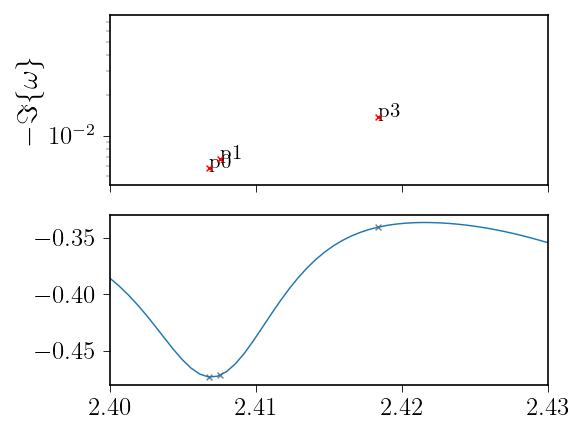

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True)
plt.sca(axs[0])
e_phs_r = np.linspace(E_min, E_max)
mask = np.logical_and(poles.real > E_min, poles.real < E_max)
plt.scatter(poles.real, -poles.imag, zorder=5, marker="x", color="red")
for idx, pole in enumerate(poles):
    pass
    plt.annotate(f"p{idx}", (pole.real, -pole.imag))

for residue, pole in zip(res,pol):
    #plt.annotate(f"r{np.abs(residue):.3e}", (pole.real, -pole.imag))
    pass

plt.yscale("log")
plt.ylabel("$-\Im\{\omega\}$")
plt.xlim(E_min, E_max)

plt.sca(axs[1])
plt.plot(e_phs_r, r(e_phs_r))
plt.scatter(poles.real[mask], r(poles.real[mask]), marker="x", color="gray")


In [39]:
plt_count = 0
def plot_poles(poles):
    global plt_count
    plt_count += 1
    
    if plt_count%2 == 0:
        return #avoid problems with double evaluation

    for idx, pole in enumerate(poles):
        plt.annotate(f"p{idx}", (pole.real, -pole.imag))
    plt.scatter(np.real(poles), -np.imag(poles), marker="x")
    plt.xlim(E_min, E_max)
    plt.ylim(5e-3, 2e-2)
    plt.yscale("log")
    plt.ylabel("$-\Im\{\omega\}$")
    plt.xlabel("$\Re\{\omega\}$")
    plt.grid(which="major", visible=True)
    plt.grid(which="minor", visible=True, linewidth=0.3)
    plt.savefig(f"out/poles{plt_count}.png")
    plt.close()

    np.save(f"out/poles{plt_count}.npy", poles)

def loss_fn(length: float):
    f_k = tm_cavity(z_k, L=length)[:,t_idx,t_idx]
    z_j, f_j, w_j, z_n = aaa(z_k, f_k)
    poles = z_n

    p_r = poles.real
    p_i = poles.imag
    p_r_mask = np.logical_and(p_r > E_min, p_r < E_max)
    p_i_mask = p_i < 0
    
    poles = poles[np.logical_and(p_r_mask, p_i_mask)]
    poles = poles[np.argsort(np.abs(poles - 2.41) + np.abs(np.imag(poles))*10)]

    jax.debug.callback(plot_poles, poles)

    return np.abs(np.real(poles[1]) - 2.415)**2

grad_fn = jax.jacfwd(loss_fn)
val_grad_fn = jax.value_and_grad(loss_fn)

In [40]:
from jax.example_libraries.optimizers import adam
init_fn, update_fn, params_fn = adam(1, 0.8, 0.99)
state = init_fn(1820.0)

def step_fn(step, state):
    latent = params_fn(state)
    #loss, grads = val_grad_fn(latent)
    grads = grad_fn(latent)
    loss = loss_fn(latent)

    optim_state = update_fn(step, grads, state)

    return loss, optim_state

In [41]:
help(val_grad_fn)

Help on function loss_fn in module __main__:

loss_fn(length: float)
    Value and gradient of loss_fn with respect to positional argument(s) 0. Takes the same arguments as loss_fn but returns a two-element tuple where the first element is the value of loss_fn and the second element is the gradient, which has the same shape as the arguments at positions 0.



In [42]:
losses = []
for step in range(30):
    loss, state = step_fn(step, state)
    losses.append(loss)
    plt.plot(losses)
    plt.savefig("out/loss.png")
    plt.close()
    print(params_fn(state))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1819.0007031577588


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1818.010891662534


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1817.0388509922093


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1816.0945555292762


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1815.1897409915466


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1814.3377696512425


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1813.55316769297


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.850748276496


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.2442559499018


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.7447442351393


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.3590139000887


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.0885382348208


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1810.9291667683299


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1810.871621393884


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1810.9025498087285


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.0058129223494


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.1637505057479


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.3582985568733


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.5719368906332


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.7884931239792


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1811.993827487928


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.176396119742


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.327662832081


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.4423179498026


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.518273549357


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.5564319391476


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.5602560425248


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.5351944071433


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.4880240560594


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

1812.4261727535602
